In [ ]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable

In [ ]:
# So we need MNIST data , tensorflow provides a MNIST data
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
# set the min batch size
mb_size = 64
# the number of samples to take from a random distribution
Z_dim = 100

# The number of training examples
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

# The size of hidden layer
h_dim = 128

# Set the initial cost to zero
c = 0

# Set the learning rate
lr = 1e-3

In [ ]:
# Lets define the 'Xavier Initialization function'
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

### Let's start with the generator network

##### First the variables

In [ ]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

##### Then the network

In [ ]:
def G(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

### The Discriminator

##### The variables

In [ ]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

##### The discriminator network

In [ ]:
def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

In [ ]:
# Store all the parameters under a single roof
G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

Lets begin to code the training process

In [ ]:
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

In [ ]:
# Declare the optimizers for generator

G_solver = optim.Adam(G_params, lr=1e-3)

# Declare the optimizers for discriminator
D_solver = optim.Adam(D_params, lr=1e-3)


# The targets for the discriminator.
# Zeros for the samples coming from generator and one for the data coming from sample space
ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))

The actual training

In [ ]:
gen_loss=[]
dis_loss=[]

for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    X, _ = mnist.train.next_batch(mb_size)
    
    #The iputs should be a troch tensor
    X = Variable(torch.from_numpy(X))

    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))
        dis_loss.append(D_loss.data.numpy())
        gen_loss.append(G_loss.data.numpy())

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        plt.savefig('out-pytorch-gan/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)

In [ ]:
import pickle
with open("./out-pytorch-gan/losses_pickles/genloss.pkl","wb") as f:
    pickle.dump(gen_loss,f)
    

In [ ]:
with open("./out-pytorch-gan/losses_pickles/disloss.pkl","wb") as f:
    pickle.dump(dis_loss,f)

In [3]:
import pickle

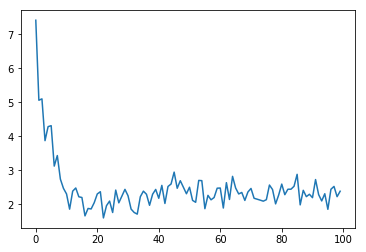

In [4]:
with open("./out-pytorch-gan/losses_pickles/genloss.pkl","rb") as f:
    gen_loss=pickle.load(f)

import matplotlib.pyplot as plt

plt.plot(gen_loss)

plt.show()

In [5]:
with open("./out-pytorch-gan/losses_pickles/disloss.pkl","rb") as f:
    dis_loss=pickle.load(f)

import matplotlib.pyplot as plt

plt.plot(dis_loss)

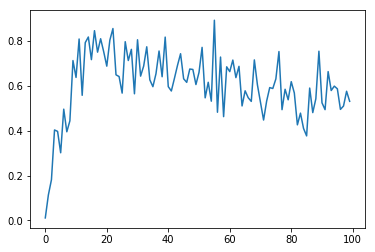

In [6]:
plt.show()